**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab6
configure_lab6()
from lab6 import *
GRADER, x,y = part_2()

--2021-10-01 12:02:35--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0s      

2021-10-01 12:02:35 (28.1 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 6 - Parte 2: Reducción de dimensión PCA y LDA

Para el problema de clasificación usaremos la siguiente base de datos: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Analice la base de datos, sus características, su variable de salida y el contexto del problema.

In [2]:
print('Dimensiones de la base de datos de entrenamiento. dim de X: ' + str(np.shape(x)) + '\tdim de Y: ' + str(np.shape(y)))

Dimensiones de la base de datos de entrenamiento. dim de X: (2126, 22)	dim de Y: (2126,)


Este ejercicio tiene como objetivo implementar varias técnicas de extracción de características (PCA y LDA) y usar RF para resolver un problema de clasificación multietiqueta o multiclase.

**observación para las librerias sklearn **

Llamar explicitamente los parametros de las librerias de sklearn (e.j. si se quiere usar el parametro `kernel` del `SVC`, se debe llamar `SVC(kernel='rbf'`)

En la siguiente celda se define una función para entrenar un SVM para resolver el problema. Esta función la vamos a usar como base para comparar nuestros metodos de selección de características.

In [3]:
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #Creamos el clasificador SVM.
        clf = SVC(kernel="linear", C=1)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Errores), np.std(Errores), np.mean(times)

### Ejercicio 1: Entrenamiento usando PCA para realizar extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [PCA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). El cual ya se encuentra importado (se pueda acceder a el como `PCA(....)`)
2. Tener en cuenta la respuesta de la siguiente pregunta abierta y completar el código de acuerdo a la respuesta usando la libreria y modulo de sklearn correspondiente (El cual tambien deberia ya estar importado en la configuración).
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la PCA.
5. Recordar que PCA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [4]:
#@title Pregunta Abierta
#@markdown ¿Cuando se aplica PCA ¿es necesario estandarizar los datos? Si, No y por qué? En qué consiste dicha estandarización?
respuesta_1 = 'Para la proyecci\xF3n An\xE1lisis de componentes principales es necesario que los elementos de la matriz que contienen los datos tengan media 0, lo que es equivalente a la estandarizaci\xF3n, adem\xE1s su aplicaci\xF3n permite realizar una extracci\xF3n de caracter\xEDsticas m\xE1s sencilla ya que se centralizan los datos al quitarle la media. ' #@param {type:"string"}

In [5]:
#@title Pregunta Abierta
#@markdown  La proyección de los datos que realiza PCA busca optimizar una medida, ¿Cuál? Explique.
respuesta_2 = 'La proyecci\xF3n de los datos que realiza PCA busca optimizar o reducir la medida de la distancia entre cada punto (datos originales) y la proyecci\xF3n, las proyecciones de los datos originales sobre las direcciones prinicipales son los componentes principales.' #@param {type:"string"}

In [6]:
#ejercicio de código
def entrenamiento_pca_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """  
    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        escalar = StandardScaler()
        X_train = escalar.fit_transform(X_train)
        X_test = escalar.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components=n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X= X_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X = X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca))
        times[j] = tiempo_o
        j+=1


    return np.mean(Errores), np.std(Errores), np.mean(times)


In [7]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", entrenamiento_pca_ext_caracteristicas)

TEST EXITOSO!


### Ejercicio 2 : Experimentar con PCA

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - T_EJECUCION: tiempo de ejecucción
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [8]:
#ejercicio de código
def experimentar_PCA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, T_EJECUCION, ERROR_VALIDACION y IC_STD_VALIDACION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'T_EJECUCION'] = t_ex
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        ERROR_VALIDACION, IC_STD_VALIDACION, T_EJECUCION = entrenamiento_pca_ext_caracteristicas(n_comp=f, X= X,Y= Y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = X.shape[0]
        df.loc[idx, 'T_EJECUCION'] = T_EJECUCION
        df.loc[idx,'ERROR_VALIDACION'] = ERROR_VALIDACION
        df.loc[idx, 'IC_STD_VALIDACION'] = IC_STD_VALIDACION
        idx+=1
    return df


In [9]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", experimentar_PCA)

termina experimento sin selección
TEST EXITOSO!


In [10]:
experimentar_PCA(n_feats=[2,5,10,15,20], X= x, Y = y)

termina experimento sin selección


,CON_SEL,NUM_VAR,T_EJECUCION,ERROR_VALIDACION,IC_STD_VALIDACION
0,NO,22.0,0.029370,0.932288,0.042333
1,SI,2126.0,0.127625,0.775725,0.143470
2,SI,2126.0,0.078913,0.912543,0.055779
3,SI,2126.0,0.087940,0.925707,0.050504
4,SI,2126.0,0.083891,0.926174,0.039771
5,SI,2126.0,0.049855,0.930877,0.041066


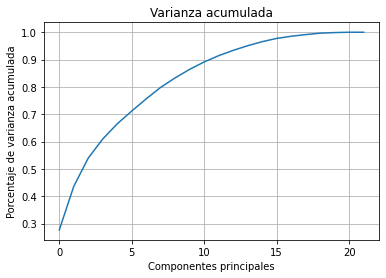

In [11]:
# aca realizamos una curva de varianza explicada del PCA
pca_varianza = PCA(n_components=x.shape[1]).fit(StandardScaler().fit_transform(x))
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.title('Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

In [12]:
#@title Pregunta Abierta
#@markdown  ¿Como se relaciona el mejor número de componentes encontrado en los experimentos con la curva de varianza explicada? Explicar con base a los resultados, la grafica y la teoria
respuesta_3 = 'La varianza equivale a la variabilidad de la informaci\xF3n por lo que durante este proceso de extracci\xF3n de caracter\xEDsticas es necesario que su valor sea grande. ' #@param {type:"string"}

ahora recordemos que el PCA tambien nos sirve para explorar y visualizar los datos en pocas dimensiones. En la siguiente celda vamos a visualizar nuestro conjunto de datos usando los dos primeros componentes principales

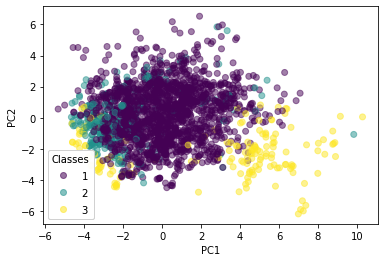

In [13]:
data_to_plot = StandardScaler().fit_transform(X=x)
fig, ax = plt.subplots()
pca = PCA(n_components=2)
x_pc2 = pca.fit_transform(data_to_plot)
scatter= ax.scatter(x= x_pc2[:,0], y = x_pc2[:,1], c = y, alpha = 0.5, label = y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [14]:
#@title Pregunta Abierta
#@markdown Aunque PCA nos sirve para ver los datos en dimensiones menores a la base de datos original, sabiendo la varianza acumulada obtenida para 2 componentes principales ¿que tan cercana es la aproximación para este problema en específico?
respuesta_4 = "'La varianza acumulado con 2 componentes principales es de aproximadamente, seg\\xFAn la gr\\xE1fica, 0,5- 50% este valor es muy menor para un correcto funcionamiento del modelo con la extracci\\xF3n de caracter\\xEDsticas, en una de las reglas definidas para las elecciones de componentes principales se dice que la varianza debe cubrir una proporci\\xF3n determinada desde el 80%, comparado con el 50% es mucha la diferencia. Adem\\xE1s en la gr\\xE1fica donde se ven esos dos componentes elegidos junto con las muestras y sus 3 clases, se visualiza que no es posible diferenciar muy bien las muestras de las clases, est\\xE1n algunas sobrepuestas o muy cercanas de las diferentes clases '" #@param {type:"string"}

### Ejercicio 3: Entrenamiento usando Discriminante de Fisher para extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [LinearDiscriminantAnalysis-LDA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html). El cual ya se encuentra importado (se pueda acceder a el como `LinearDiscriminantAnalysis(....)`)
2. ¿También se estandarizar los datos?
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud/accuracy como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la LDA.
5. Recordar que LDA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [15]:
#@title Pregunta Abierta
#@markdown Explicar en sus palabras la principal ventaja que tiene LDA sobre PCA para resolver problemas de clasificación.
respuesta_5 = 'La principal ventaja que tiene LDA sobre PCA en clasificaci\xF3n, es que es una t\xE9cnica supervisada, basada en la proyecci\xF3n de los datos en la mejor direcci\xF3n ya que se adopta mejor a la discriminaci\xF3n del conjunto de datos.  ' #@param {type:"string"}

In [16]:
#ejercicio de código
def entrenamiento_lda_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna:
    T_ejec:  El  valor medio del tiempo de ejecución
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    """
   

    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        escalar = StandardScaler()
        X_train = escalar.fit_transform(X = X_train)
        X_test = escalar.transform(X = X_test)
        # dejar el nombre del objeto igual (lda)
        lda = LinearDiscriminantAnalysis(n_components= n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_lda = lda.fit_transform(X_train, y_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_lda = lda.transform(X = X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_lda, y= y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_lda))
        times[j] = tiempo_o
        j+=1


    return np.mean(times), np.mean(Errores), np.std(Errores)

In [17]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", entrenamiento_lda_ext_caracteristicas)

TEST EXITOSO!


### Ejercicio 4 : Experimentar con Discriminante de Fisher

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
    - T_EJECUCION: tiempo de ejecucción
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [18]:
#ejercicio de código
def experimentar_LDA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    ERROR_VALIDACION,IC_STD_VALIDACION,T_EJECUCION = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'ERROR_VALIDACION'] = ERROR_VALIDACION
    df.loc[idx,'IC_STD_VALIDACION'] = IC_STD_VALIDACION
    df.loc[idx,'T_EJECUCION'] = T_EJECUCION
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        T_EJECUCION, ERROR_VALIDACION, IC_STD_VALIDACION = entrenamiento_lda_ext_caracteristicas(n_comp=f, X=x,Y=y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'ERROR_VALIDACION'] = ERROR_VALIDACION
        df.loc[idx, 'IC_STD_VALIDACION'] = IC_STD_VALIDACION
        df.loc[idx, 'T_EJECUCION'] = T_EJECUCION
        idx+=1
    return df


In [19]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", experimentar_LDA)

termina experimento sin selección
TEST EXITOSO!


In [20]:
experimentar_LDA(n_feats=[1,2], X= x, Y = y)

termina experimento sin selección


,CON_SEL,NUM_VAR,ERROR_VALIDACION,IC_STD_VALIDACION,T_EJECUCION
0,NO,22.0,0.932288,0.042333,0.031613
1,SI,22.0,0.835434,0.106180,0.037121
2,SI,22.0,0.923810,0.035584,0.034757


In [21]:
#@title Pregunta Abierta
#@markdown  ¿que diferencias existen entre los métodos de selección de características y los métodos de extracción de características vistos en la anterior sesión? Explicar
respuesta_6 = 'La selecci\xF3n de caracter\xEDsticas permite extraer informaci\xF3n reduciendo el conjunto de variables, elegimos un subconjunto de ellas, mientras que en la extracci\xF3n de caracter\xEDsticas se obtienen nuevas variables que condensan la informaci\xF3n de las originales. En la selecci\xF3n se verifica si un subconjunto es bueno o no con m\xE9todos como Filtro y Wrapper y en la extracci\xF3n se hacen diferentes combinaciones de variable que conserven la mayor informaci\xF3n posible, con PCA y LDA.' #@param {type:"string"}

In [22]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [ ]:
#@title Integrantes
codigo_integrante_1 ='1000415078' #@param {type:"string"}
codigo_integrante_2 = '1035833769'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()